# Workflow to solve v_inner boundary

The source code for this workflow can be found at: https://github.com/tardis-sn/tardis/blob/master/tardis/workflows/v_inner_solver.py.

This workflow demonstrates how to use the TARDIS modules to perform targeted tasks. This workflow is built on top of the [SimpleTARDISWorkflow](https://github.com/tardis-sn/tardis/blob/master/tardis/workflows/simple_tardis_workflow.py) to solve the v_inner boundary, in addition to the remaining radiative properties.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u

In [2]:
from tardis.workflows.v_inner_solver import InnerVelocitySolverWorkflow
from tardis.io.configuration.config_reader import Configuration

/home/runner/work/tardis/tardis/tardis/__init__.py:17: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [3]:
config = Configuration.from_yaml('../tardis_example.yml')

This code modifies the TARDIS example configuration to include convergence information for the inner boundary velocity solver.

In [4]:
config.montecarlo.convergence_strategy['v_inner_boundary'] = {
    'damping_constant' : 0.5,
    'threshold' : 0.01,
    'type' : 'damped',
    'store_iteration_properties' : True
    }

config.montecarlo.convergence_strategy.stop_if_converged = True 
config.model.structure.velocity.start = 5000 * u.km/u.s # Decrease start velocity from 11000 km/s in example file, to search over a wider range
config.model.structure.velocity.num = 50 # Increase number of shells from 20 in example file, to provide more granularity

workflow = InnerVelocitySolverWorkflow(
    config, tau=2.0/3,
    mean_optical_depth="rosseland"
)

Tabs(height=350, sizing_mode='stretch_width')
    [0] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [1] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [2] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [3] HTML(str, height=300, styles={'overflow-y': 'auto', ...})

Tabs(height=350, sizing_mode='stretch_width')
    [0] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [1] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [2] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [3] HTML(str, height=300, styles={'overflow-y': 'auto', ...})

In [5]:
workflow.run()

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04 K,1.59e+04 K,0.0531,0.485
5,1.44e+04 K,1.66e+04 K,0.0407,0.214
10,1.43e+04 K,1.68e+04 K,0.0323,0.125
15,1.42e+04 K,1.63e+04 K,0.0262,0.0917
20,1.42e+04 K,1.57e+04 K,0.0217,0.0755
25,1.41e+04 K,1.5e+04 K,0.0183,0.0669


Shell No.,t_rad,next_t_rad,w,next_w
0,1.59e+04 K,1.24e+04 K,0.485,0.461
5,1.66e+04 K,1.38e+04 K,0.214,0.16
10,1.68e+04 K,1.39e+04 K,0.125,0.0937
15,1.63e+04 K,1.38e+04 K,0.0917,0.0666
20,1.57e+04 K,1.34e+04 K,0.0755,0.0551
25,1.5e+04 K,1.28e+04 K,0.0669,0.0492


Shell No.,t_rad,next_t_rad,w,next_w
0,1.24e+04 K,1.14e+04 K,0.461,0.512
5,1.38e+04 K,1.25e+04 K,0.16,0.199
10,1.39e+04 K,1.28e+04 K,0.0937,0.111
15,1.38e+04 K,1.27e+04 K,0.0666,0.0776
20,1.34e+04 K,1.23e+04 K,0.0551,0.0632
25,1.28e+04 K,1.19e+04 K,0.0492,0.0561


Shell No.,t_rad,next_t_rad,w,next_w
0,1.14e+04 K,1.12e+04 K,0.512,0.508
5,1.25e+04 K,1.18e+04 K,0.199,0.226
10,1.28e+04 K,1.2e+04 K,0.111,0.135
15,1.27e+04 K,1.21e+04 K,0.0776,0.0899
20,1.23e+04 K,1.18e+04 K,0.0632,0.0736
25,1.19e+04 K,1.14e+04 K,0.0561,0.0651


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.09e+04 K,0.508,0.532
5,1.18e+04 K,1.14e+04 K,0.226,0.235
10,1.2e+04 K,1.15e+04 K,0.135,0.145
15,1.21e+04 K,1.14e+04 K,0.0899,0.106
20,1.18e+04 K,1.12e+04 K,0.0736,0.0848
25,1.14e+04 K,1.08e+04 K,0.0651,0.0749


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04 K,1.09e+04 K,0.532,0.509
5,1.14e+04 K,1.12e+04 K,0.235,0.241
10,1.15e+04 K,1.12e+04 K,0.145,0.153
15,1.14e+04 K,1.1e+04 K,0.106,0.114
20,1.12e+04 K,1.08e+04 K,0.0848,0.0915
25,1.08e+04 K,1.05e+04 K,0.0749,0.0792


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04 K,1.08e+04 K,0.0563,0.561
5,1.13e+04 K,1.13e+04 K,0.263,0.25
10,1.12e+04 K,1.13e+04 K,0.162,0.155
15,1.11e+04 K,1.11e+04 K,0.12,0.115
20,1.09e+04 K,1.08e+04 K,0.0945,0.0928
25,1.06e+04 K,1.06e+04 K,0.081,0.0796
30,1.02e+04 K,1.03e+04 K,0.0744,0.0702


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04 K,1.09e+04 K,0.561,0.578
5,1.13e+04 K,1.14e+04 K,0.25,0.253
10,1.13e+04 K,1.14e+04 K,0.155,0.156
15,1.11e+04 K,1.12e+04 K,0.115,0.115
20,1.08e+04 K,1.09e+04 K,0.0928,0.0957
25,1.06e+04 K,1.07e+04 K,0.0796,0.08
30,1.03e+04 K,1.04e+04 K,0.0702,0.0716


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04 K,1.1e+04 K,0.578,0.57
5,1.14e+04 K,1.13e+04 K,0.253,0.255
10,1.14e+04 K,1.14e+04 K,0.156,0.157
15,1.12e+04 K,1.12e+04 K,0.115,0.116
20,1.09e+04 K,1.09e+04 K,0.0957,0.0938
25,1.07e+04 K,1.07e+04 K,0.08,0.0802
30,1.04e+04 K,1.03e+04 K,0.0716,0.0718


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.09e+04 K,0.57,0.565
5,1.13e+04 K,1.14e+04 K,0.255,0.25
10,1.14e+04 K,1.14e+04 K,0.157,0.158
15,1.12e+04 K,1.11e+04 K,0.116,0.119
20,1.09e+04 K,1.1e+04 K,0.0938,0.0935
25,1.07e+04 K,1.06e+04 K,0.0802,0.081
30,1.03e+04 K,1.03e+04 K,0.0718,0.0731


## Plot the spectrum

In [6]:
spectrum = workflow.spectrum_solver.spectrum_real_packets
spectrum_virtual = workflow.spectrum_solver.spectrum_virtual_packets
spectrum_integrated = workflow.spectrum_solver.spectrum_integrated

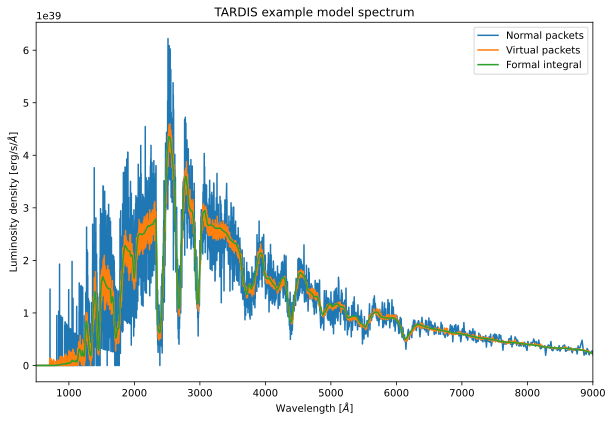

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 6.5))

spectrum.plot(label="Normal packets")
spectrum_virtual.plot(label="Virtual packets")
spectrum_integrated.plot(label='Formal integral')

plt.xlim(500, 9000)
plt.title("TARDIS example model spectrum")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Luminosity density [erg/s/$\AA$]")
plt.legend()
plt.show()

## Plot the convergence process

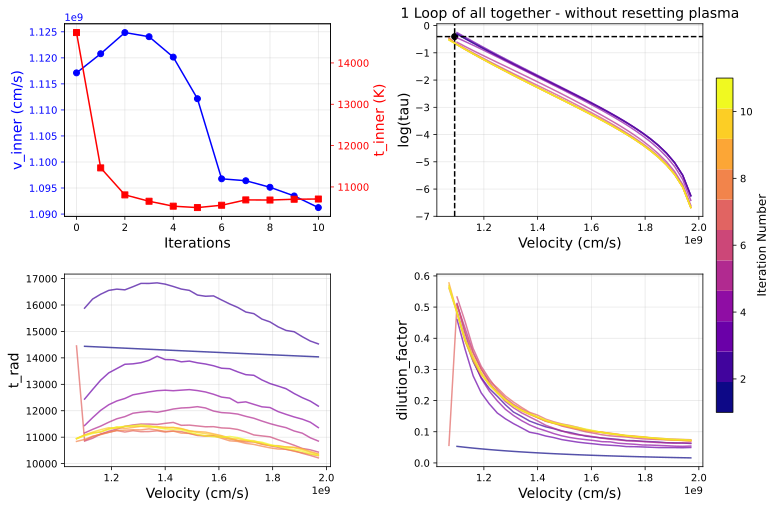

In [8]:
%matplotlib inline

# extract plasma states
t_rad = workflow.iterations_t_rad
t_inner = workflow.iterations_t_inner
w = workflow.iterations_w
taus = workflow.iterations_mean_optical_depth
v_inner = workflow.iterations_v_inner_boundary

# remove all nans, or rows where all values are nan
t_rad = t_rad[~np.all(np.isnan(t_rad), axis=1)]
t_inner = t_inner[~np.isnan(t_inner)]
w = w[~np.all(np.isnan(w), axis=1)]
taus = taus[~np.all(np.isnan(taus), axis=1)]  
v_inner = v_inner[~np.isnan(v_inner)]

# initialize figure
fig,axes =  plt.subplots(2,2,figsize=(12,8))
plt.subplots_adjust(wspace=0.4,hspace=0.3)

# get the raw velocity grid 
vel = workflow.simulation_state.geometry.v_inner

# pick a colormap for the iterations
cmap = plt.get_cmap('plasma',taus.shape[0])

# plot v inner change
v_inner_plot = axes[0,0]
v_inner_plot.plot(v_inner,marker="o",color="b")
v_inner_plot.set_xlabel("Iterations", fontsize=14)
v_inner_plot.set_ylabel("v_inner (cm/s)", fontsize=14)
v_inner_plot.grid(alpha=0.3)
v_inner_plot.tick_params(axis='y', colors='blue')
v_inner_plot.yaxis.label.set_color('blue')

# plot t inner change in same subplot
t_inner_plot = axes[0][0].twinx()
t_inner_plot.plot(t_inner,marker="s",color="r")
t_inner_plot.set_ylabel("t_inner (K)", fontsize=14)
t_inner_plot.tick_params(axis='y', colors='red')
t_inner_plot.yaxis.label.set_color('red')

# plot the tau change
tau_plot = axes[0][1]
for i, tau in enumerate(taus):
    tau_plot.plot(vel[-len(tau):], tau, color=cmap(i/taus.shape[0]),label=f"itr {i+1}",alpha=0.7)
tau_plot.scatter(workflow.simulation_state.v_inner_boundary.value, np.log(2.0 / 3.0), color="k",marker="o")
tau_plot.axhline(np.log(2.0 / 3.0), color='black', linestyle='--')
tau_plot.axvline(workflow.simulation_state.v_inner_boundary.value, color='k', linestyle='--')
tau_plot.set_xlabel("Velocity (cm/s)", fontsize=14)
tau_plot.set_ylabel("log(tau)", fontsize=14)
tau_plot.grid(alpha=0.3)
tau_plot.set_title("1 Loop of all together - without resetting plasma", fontsize=14)

# plot t radiative change
t_rad_plot = axes[1][0]
for i in range(len(taus)):
    t_rad_plot.plot(vel[-len(t_rad[i]):], t_rad[i],color=cmap(i/taus.shape[0]),label=f"itr {i+1}",alpha=0.7)
t_rad_plot.set_xlabel("Velocity (cm/s)", fontsize=14)
t_rad_plot.set_ylabel("t_rad", fontsize=14)
t_rad_plot.grid(alpha=0.3)

# plot dilution factor change
w_plot = axes[1][1]
for i in range(len(taus)):
    w_plot.plot(vel[-len(w[i]):], w[i],color=cmap(i/taus.shape[0]),label=f"itr {i+1}",alpha=0.7)
w_plot.set_xlabel("Velocity (cm/s)", fontsize=14)
w_plot.set_ylabel("dilution_factor", fontsize=14)
w_plot.grid(alpha=0.3)

# add colorbar for iteration number
norm = mpl.colors.Normalize(vmin=1, vmax=len(taus))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label('Iteration Number', fontsize=12)